## DataLab 4 | Portfolio Performance Attribution & Factor Model | Problem Set Solutions

Note 1: Review what you have learned in Data labs, DataCamp assignments, and in-class sample code.  
Note 2: Chapter "Performance Attribution" of DataCamp course "Introduction to Portfolio Analysis in Python"  is a useful reference.  
Note 3: This note serves as a guide. You are free to tinker with it! 

### 1. Revisit the All-Weather Portfolio You Crafted. 

Create the maximum Sharpe portfolio's daily return dataframe and then merge it with Fama French's five return factors.  

In [10]:
# Import the necessary packages
import refinitiv.data.eikon as ek
import datetime as dt 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
ek.set_app_key('DEFAULT_CODE_BOOK_APP_KEY')

In [11]:
# Pick a list of stocks that form your all-weather portfolio
# Draw data for the past five years

# Illustrative, change into yours!
symbols_list = ['AAPL.O','KMI','CCJ', 'BP']

In [12]:
# Note the start-end times as '2018-08-31', '2023-08-31'
# Define date ranges (splitting by year, in order to get around data retrieval limits)
date_ranges = [('2018-08-31', '2019-08-31'), ('2019-09-01', '2020-08-31'), 
               ('2020-09-01', '2021-08-31'), ('2021-09-01', '2022-08-31'), 
               ('2022-09-01', '2023-08-31')]

# Initialize empty DataFrame
price = pd.DataFrame()

# Loop through date ranges and fetch data
for start_date, end_date in date_ranges:
    temp_data = ek.get_timeseries(symbols_list, fields='CLOSE', start_date=start_date, end_date=end_date, corax='adjusted')
    price = pd.concat([price, temp_data])

In [13]:
# Calculate return using method pct_change
# Find out more about .pct_change with help! 
daily_returns = price.pct_change()[1:]

# deep dive into the first five rows of observations in the dataframe
daily_returns.head()

CLOSE,AAPL.O,KMI,CCJ,BP
Date,,,,
2018-09-04,0.003207,-0.00452,-0.028818,-0.003731
2018-09-05,-0.006525,0.009648,-0.013848,0.001404
2018-09-06,-0.016617,-0.006745,-0.021063,-0.013324
2018-09-07,-0.008068,0.008489,-0.004098,-0.004264
2018-09-10,-0.013421,-0.007295,-0.030864,0.001428


In [14]:
# function that takes portfolio weights and creates a time-series of daily portfolio returns
def portfolio_return_series(daily_returns, weights):
    
    ''' 
    INPUTS
    daily returns: dataframe of daily returns. Each ticker column contains the series of daily returns for the ticker
    weights: numpy array of the portfolio weight on each ticker (sorted in ascending order)
    
    OUTPUTS
    portfolio_daily_returns: the portfolio return series given the weights
    
    '''    

    # Create portfolio daily returns
    portfolio_daily_returns = daily_returns.dot(weights)
    
    # Calculate cumulative returns
    # Hint: Use .cumprod()
    portfolio_cumulative_returns=(1 + portfolio_daily_returns).cumprod()
    
    return portfolio_daily_returns, portfolio_cumulative_returns

In [15]:
# Import the packages 
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier

**The Maximum Sharpe Portfolio**

In [16]:
# Calculate expected returns mu 
mu = expected_returns.mean_historical_return(price)

# Calculate the covariance matrix S
sigma = risk_models.sample_cov(price)

# Obtain the efficient frontier
ef = EfficientFrontier(mu, sigma)

# Calculate weights for the maximum Sharpe ratio portfolio
raw_weights_maxsharpe = ef.max_sharpe()
cleaned_weights_maxsharpe = ef.clean_weights()
optimal_weights_maxsharpe = np.array(list(cleaned_weights_maxsharpe.values())) # Get interpretable weights
print(f"{raw_weights_maxsharpe}\n{cleaned_weights_maxsharpe}\n{optimal_weights_maxsharpe}")

OrderedDict([('AAPL.O', 0.7208626311942508), ('KMI', 0.0), ('CCJ', 0.2791373688057494), ('BP', 0.0)])
OrderedDict([('AAPL.O', 0.72086), ('KMI', 0.0), ('CCJ', 0.27914), ('BP', 0.0)])
[0.72086 0.      0.27914 0.     ]


**The Minimum Volatility Portfolio**

In [17]:
# Obtain the efficient frontier
ef2 = EfficientFrontier(mu, sigma)
# Calculate weights for the minimum volatility portfolio
raw_weights_minvol = ef2.min_volatility()
cleaned_weights_minvol = ef2.clean_weights()
optimal_weights_minvol = np.array(list(cleaned_weights_minvol.values())) # Get interpretable weights
print(f"{raw_weights_minvol}\n{cleaned_weights_minvol}\n{optimal_weights_minvol}")

OrderedDict([('AAPL.O', 0.4367622431709234), ('KMI', 0.3670070744074508), ('CCJ', 0.073259837556671), ('BP', 0.1229708448649547)])
OrderedDict([('AAPL.O', 0.43676), ('KMI', 0.36701), ('CCJ', 0.07326), ('BP', 0.12297)])
[0.43676 0.36701 0.07326 0.12297]


In [18]:
# 1. Daily portfolio returns for the equally-weighted portfolio
# Change the equal weights according to the number of stocks you have
weights_ew = [.25,.25,.25,.25]
# Extract the first element from the function output for daily returns
portfolio_ew = portfolio_return_series(daily_returns, weights_ew)[0]
# Extract the second element from the function output for cumulative returns
cumulative_portfolio_ew = portfolio_return_series(daily_returns, weights_ew)[1]

# 2. Daily portfolio returns for the maximum Sharpe portfolio
# Extract the first element from the function output for daily returns
portfolio_maxsharpe = portfolio_return_series(daily_returns, optimal_weights_maxsharpe)[0]
# Extract the second element from the function output for cumulative returns
cumulative_portfolio_maxsharpe = portfolio_return_series(daily_returns, optimal_weights_maxsharpe)[1]

# 3. Daily portfolio returns for the minimum volatility portfolio
# Extract the first element from the function output for daily returns
portfolio_minvol = portfolio_return_series(daily_returns, optimal_weights_minvol)[0]
# Extract the second element from the function output for cumulative returns
cumulative_portfolio_minvol = portfolio_return_series(daily_returns, optimal_weights_minvol)[1]

Next, we want to introduce the Fama-French 5-factor 2x3 dataset into our code. The file can be retrieved from http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html#Research and is created by CMPT_ME_BEME_OP_INV_RETS_DAILY using the 202208 CRSP database. The 1-month TBill return is from Ibbotson and Associates. For more details on the factor returns, please read http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_5_factors_2x3.html.

In [19]:
# Extract data from .csv for Fama French's five return factors
FF_df = pd.read_csv("F-F_Research_Data_5_Factors_2x3_daily.csv",skiprows=3,index_col=0, parse_dates=True)
FF_df.columns = ['Mkt-RF','SMB','HML','RMW','CMA','RF']
print(FF_df)
print(FF_df.info())

            Mkt-RF   SMB   HML   RMW   CMA     RF
Date                                             
1963-07-01   -0.67  0.02 -0.35  0.03  0.13  0.012
1963-07-02    0.79 -0.28  0.28 -0.08 -0.21  0.012
1963-07-03    0.63 -0.18 -0.10  0.13 -0.25  0.012
1963-07-05    0.40  0.09 -0.28  0.07 -0.30  0.012
1963-07-08   -0.63  0.07 -0.20 -0.27  0.06  0.012
...            ...   ...   ...   ...   ...    ...
2024-05-24    0.72  0.16  0.16  0.30 -0.39  0.020
2024-05-28   -0.04  0.13 -0.90  0.11 -1.12  0.020
2024-05-29   -0.77 -0.40 -0.62  0.47 -0.02  0.020
2024-05-30   -0.53  1.37  1.00  0.34  1.07  0.020
2024-05-31    0.68 -0.02  0.78  0.94  0.80  0.020

[15334 rows x 6 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15334 entries, 1963-07-01 to 2024-05-31
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  15334 non-null  float64
 1   SMB     15334 non-null  float64
 2   HML     15334 non-null  float64
 3   RMW     1

In [20]:
# Merge Max Sharpe portfolio return the Fama French's five return factors as a date-indexed dataframe.  
portfolio_maxsharpe = pd.to_numeric(portfolio_maxsharpe, errors='coerce')
cumulative_portfolio_maxsharpe = pd.to_numeric(cumulative_portfolio_maxsharpe, errors='coerce')
portfolio_returns_and_factors = pd.concat([portfolio_maxsharpe,cumulative_portfolio_maxsharpe,FF_df],axis=1)
portfolio_returns_and_factors = portfolio_returns_and_factors.dropna()

# Rename column names
portfolio_returns_and_factors.columns = ['port_ms_daily','port_ms_cumret','Mkt-RF','SMB','HML','RMW','CMA','RF']
print(portfolio_returns_and_factors)

            port_ms_daily  port_ms_cumret  Mkt-RF   SMB   HML   RMW   CMA  \
Date                                                                        
2018-09-04      -0.005733        0.994267   -0.11 -0.34  0.01 -0.05 -0.15   
2018-09-05      -0.008569        0.985748   -0.41 -0.04  0.66  0.46  0.59   
2018-09-06      -0.017858        0.968144   -0.44 -0.36 -0.24  0.42  0.33   
2018-09-07      -0.006960        0.961405   -0.18  0.08 -0.21  0.03  0.05   
2018-09-10      -0.018290        0.943821    0.23  0.08 -0.37  0.08 -0.25   
...                   ...             ...     ...   ...   ...   ...   ...   
2023-08-25       0.014192        3.646646    0.65 -0.24 -0.58 -0.36 -0.17   
2023-08-28       0.008065        3.676056    0.63  0.09  0.41  0.26  0.03   
2023-08-29       0.015036        3.731328    1.50 -0.08 -0.10 -0.05 -0.44   
2023-08-30       0.017108        3.795164    0.41  0.09 -0.45 -0.42 -0.03   
2023-08-31       0.001299        3.800092   -0.08 -0.19  0.21  0.06 -0.26   

In [21]:
# Inspect the last five observations of the portfolio_returns dataframe
portfolio_returns_and_factors.tail()

,port_ms_daily,port_ms_cumret,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,,,
2023-08-25,0.014192,3.646646,0.65,-0.24,-0.58,-0.36,-0.17,0.02
2023-08-28,0.008065,3.676056,0.63,0.09,0.41,0.26,0.03,0.02
2023-08-29,0.015036,3.731328,1.50,-0.08,-0.10,-0.05,-0.44,0.02
2023-08-30,0.017108,3.795164,0.41,0.09,-0.45,-0.42,-0.03,0.02
2023-08-31,0.001299,3.800092,-0.08,-0.19,0.21,0.06,-0.26,0.02


In [22]:
# Print correlation table for portfolio returns and 5 factors (Note that the correlations are based on my designed timeframe)
correl_mytimeframe = portfolio_returns_and_factors.corr() 
print(f"Correlations of each factor and portfolio returns with data based on dates between Sep-18 to Aug-23:\n {correl_mytimeframe}")

# What about the original factors data's correlations?
correl_ori = FF_df.corr()
print(f"\nCorrelations of each factor with data based on original dataset's dates:\n{correl_ori}")

Correlations of each factor and portfolio returns with data based on dates between Sep-18 to Aug-23:
                 port_ms_daily  port_ms_cumret    Mkt-RF       SMB       HML  \
port_ms_daily        1.000000        0.022108  0.815452  0.086231 -0.201929   
port_ms_cumret       0.022108        1.000000  0.004658  0.009681  0.038212   
Mkt-RF               0.815452        0.004658  1.000000  0.203766 -0.071628   
SMB                  0.086231        0.009681  0.203766  1.000000  0.302775   
HML                 -0.201929        0.038212 -0.071628  0.302775  1.000000   
RMW                 -0.161706        0.027241 -0.145686 -0.226725  0.432753   
CMA                 -0.258805        0.023923 -0.342841 -0.011870  0.637702   
RF                  -0.018630        0.180232 -0.013480 -0.032316 -0.037428   

                     RMW       CMA        RF  
port_ms_daily  -0.161706 -0.258805 -0.018630  
port_ms_cumret  0.027241  0.023923  0.180232  
Mkt-RF         -0.145686 -0.342841 -0.013480 

### 2. Examine Visually the Correlation Between Portfolio and Factor Returns

Hint: *Write functions for repetitive lines of codes*

In [23]:
portfolio_ew = pd.to_numeric(portfolio_ew, errors='coerce')
portfolio_maxsharpe = pd.to_numeric(portfolio_maxsharpe, errors='coerce')
portfolio_minvol = pd.to_numeric(portfolio_minvol, errors='coerce')
portfolio_factors = pd.concat([portfolio_ew, portfolio_maxsharpe,portfolio_minvol,FF_df],axis=1)
portfolio_factors.columns = ['portfolio_ew','portfolio_maxsharpe','portfolio_minvol','Mkt-RF','SMB','HML','RMW','CMA','RF']
portfolio_factors = portfolio_factors.dropna()
print(portfolio_factors)

            portfolio_ew  portfolio_maxsharpe  portfolio_minvol  Mkt-RF   SMB  \
Date                                                                            
2018-09-04     -0.008466            -0.005733         -0.002828   -0.11 -0.34   
2018-09-05     -0.002330            -0.008569         -0.000151   -0.41 -0.04   
2018-09-06     -0.014437            -0.017858         -0.012915   -0.44 -0.36   
2018-09-07     -0.001985            -0.006960         -0.001233   -0.18  0.08   
2018-09-10     -0.012538            -0.018290         -0.010625    0.23  0.08   
...                  ...                  ...               ...     ...   ...   
2023-08-25      0.011961             0.014192          0.010504    0.65 -0.24   
2023-08-28      0.007400             0.008065          0.006397    0.63  0.09   
2023-08-29      0.009273             0.015036          0.012792    1.50 -0.08   
2023-08-30      0.008875             0.017108          0.009656    0.41  0.09   
2023-08-31     -0.003192    

In [24]:
# function that takes portfolio and factor returns and creates 20-day rolling correlation with a return factor
def portfolio_factor_correlation(portfolio_type,df):
    
    ''' 
    INPUTS
    portfolio type: portfolio_ew, portfolio_maxsharpe, portfolio_minvol
    df: dataframe containing portfolio and factor returns
    
    OUTPUTS
    plot object of the correlation between a portfolio and all factor returns
    
    '''    
    # Calculate correlation
    corr = df[portfolio_type].rolling(window=20).corr(df.loc[:,['Mkt-RF','SMB','HML','RMW','CMA']])
    corr = corr.dropna()  # To delete the first 19 rows as rolling window is 20 
    print(corr)
    plt.figure(figsize=(30, 8))
    for column in corr.columns:
        plt.plot(corr.index, corr[column], label=column)
    plt.title('20-day Rolling Correlations with Factors')
    plt.legend()
    plt.xlabel("Year")
    plt.ylabel('Correlation')
    
    return

              Mkt-RF       SMB       HML       RMW       CMA
Date                                                        
2018-10-01  0.475896 -0.148281 -0.213500 -0.239757 -0.393499
2018-10-02  0.460636 -0.170210 -0.191965 -0.253759 -0.421573
2018-10-03  0.458863 -0.079831 -0.132862 -0.259063 -0.426504
2018-10-04  0.307517 -0.119958 -0.118418 -0.145599 -0.325283
2018-10-05  0.369174 -0.076711 -0.159207 -0.038512 -0.370094
...              ...       ...       ...       ...       ...
2023-08-25  0.669447  0.108512 -0.217285 -0.411843 -0.312047
2023-08-28  0.683817 -0.100403 -0.183926 -0.247002 -0.352298
2023-08-29  0.703309 -0.077187 -0.158073 -0.278988 -0.419214
2023-08-30  0.646115 -0.002659 -0.043544 -0.191474 -0.177341
2023-08-31  0.657903 -0.018162 -0.070552 -0.206089 -0.147709

[1238 rows x 5 columns]


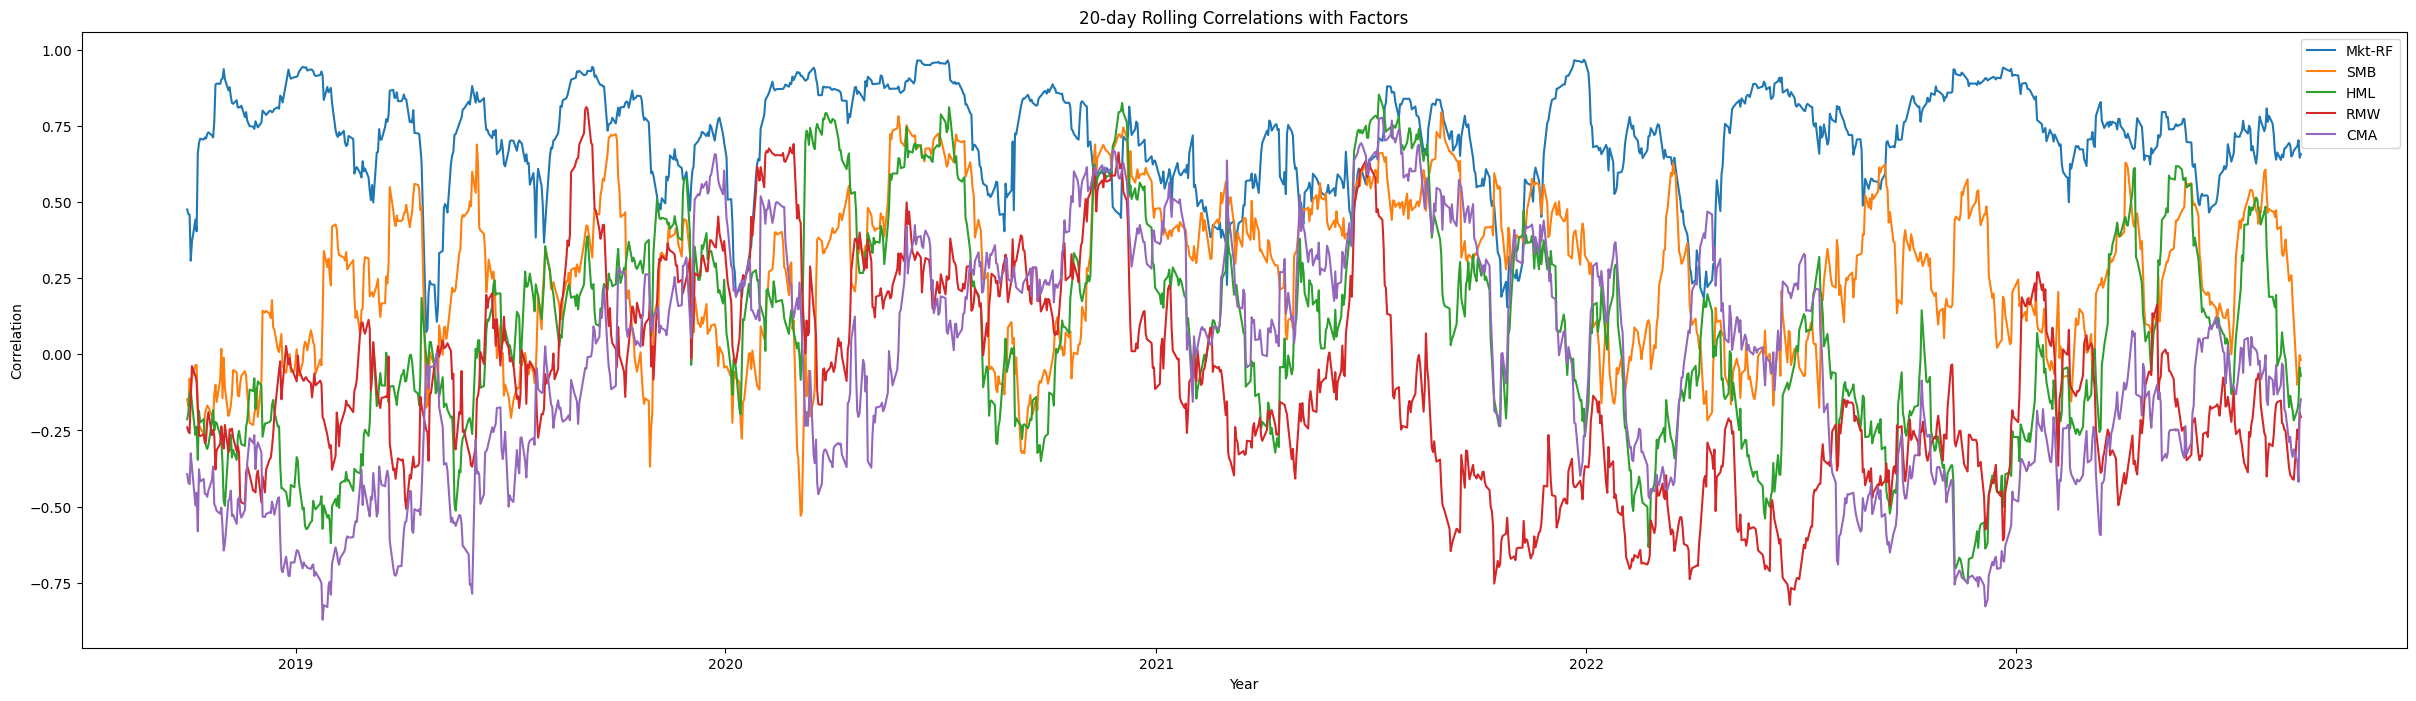

In [25]:
portfolio_factor_correlation("portfolio_ew", portfolio_factors)

              Mkt-RF       SMB       HML       RMW       CMA
Date                                                        
2018-10-01  0.535706 -0.052142 -0.372138 -0.265636 -0.557161
2018-10-02  0.505844 -0.099613 -0.320801 -0.260219 -0.542778
2018-10-03  0.497355 -0.005965 -0.247613 -0.256468 -0.542884
2018-10-04  0.399109 -0.017297 -0.259877 -0.173671 -0.478814
2018-10-05  0.442050  0.022129 -0.296537 -0.077737 -0.513897
...              ...       ...       ...       ...       ...
2023-08-25  0.699366 -0.033608 -0.562769 -0.449065 -0.280026
2023-08-28  0.702596 -0.180737 -0.525500 -0.376292 -0.294097
2023-08-29  0.725618 -0.154345 -0.504523 -0.401063 -0.348069
2023-08-30  0.688358 -0.083005 -0.473720 -0.391853 -0.186182
2023-08-31  0.687733 -0.080162 -0.467794 -0.391415 -0.192597

[1238 rows x 5 columns]


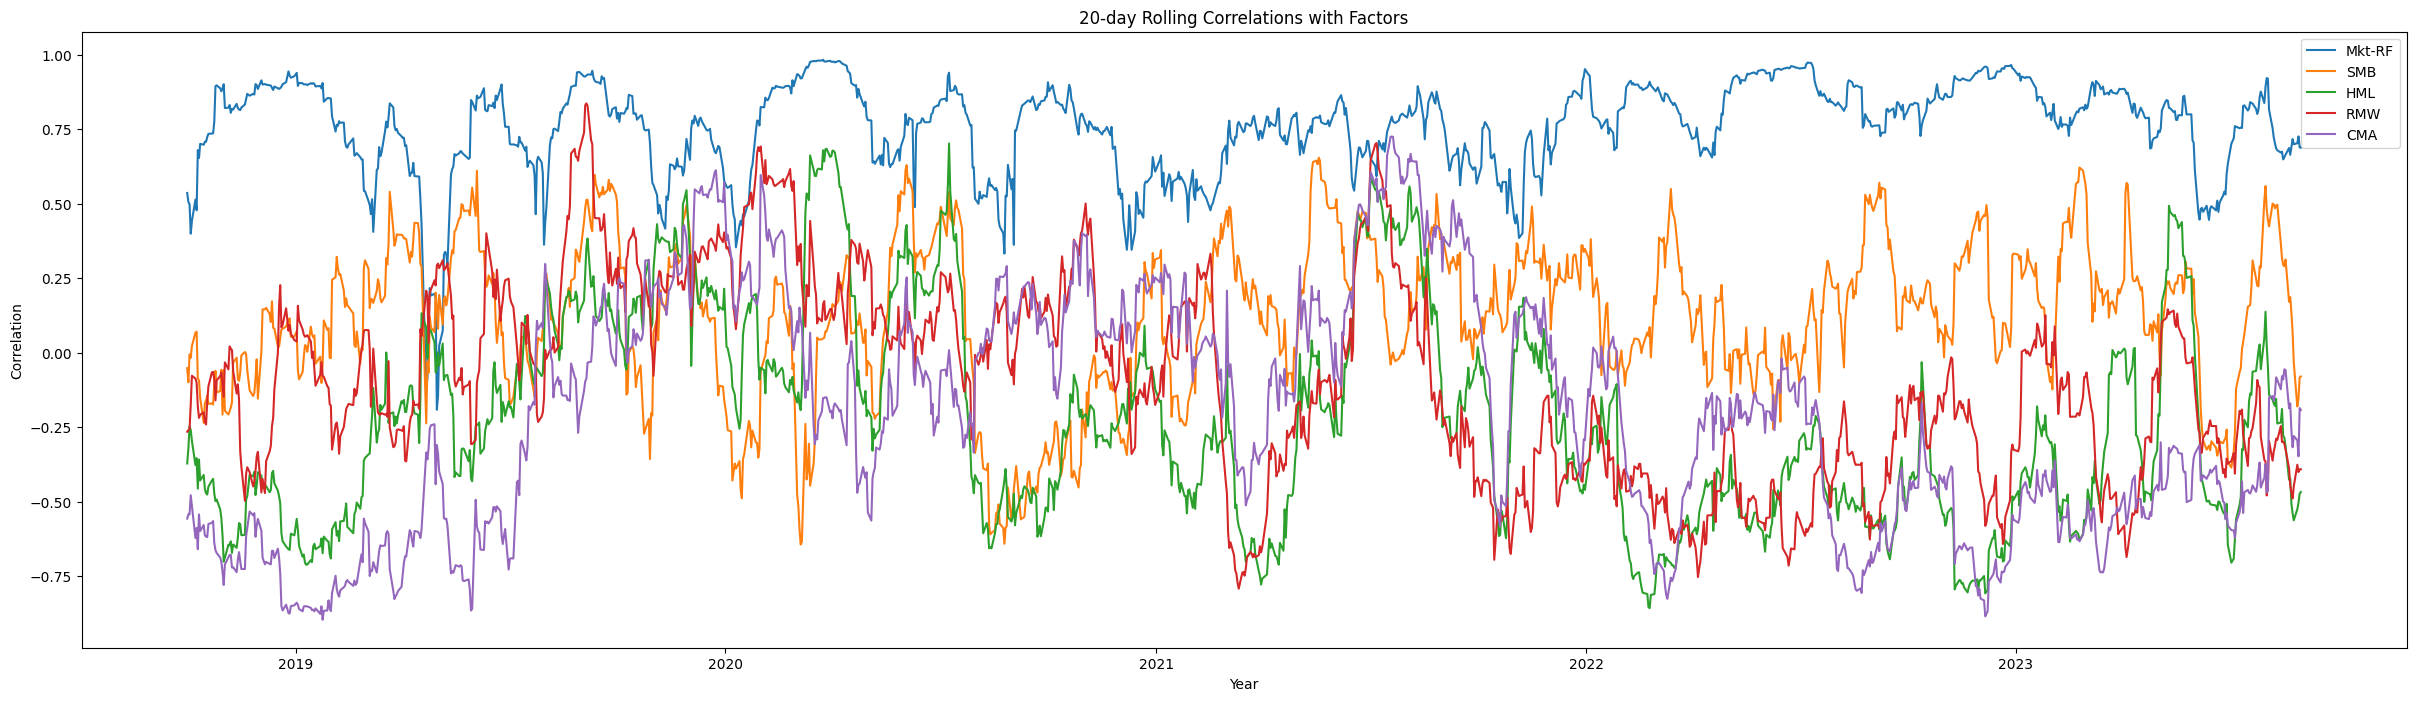

In [26]:
portfolio_factor_correlation("portfolio_maxsharpe", portfolio_factors)

              Mkt-RF       SMB       HML       RMW       CMA
Date                                                        
2018-10-01  0.522955 -0.298443 -0.165041 -0.402816 -0.467726
2018-10-02  0.508748 -0.301367 -0.146203 -0.407426 -0.475017
2018-10-03  0.523567 -0.164457 -0.086253 -0.451408 -0.508705
2018-10-04  0.475091 -0.154006 -0.194533 -0.382487 -0.494965
2018-10-05  0.533475 -0.107409 -0.230013 -0.234874 -0.529063
...              ...       ...       ...       ...       ...
2023-08-25  0.687601  0.088495 -0.370816 -0.430486 -0.190043
2023-08-28  0.696986 -0.049596 -0.326805 -0.327587 -0.203217
2023-08-29  0.739788 -0.020911 -0.300351 -0.359384 -0.277083
2023-08-30  0.699465  0.050714 -0.248104 -0.330075 -0.082264
2023-08-31  0.700406  0.047393 -0.262493 -0.330820 -0.067603

[1238 rows x 5 columns]


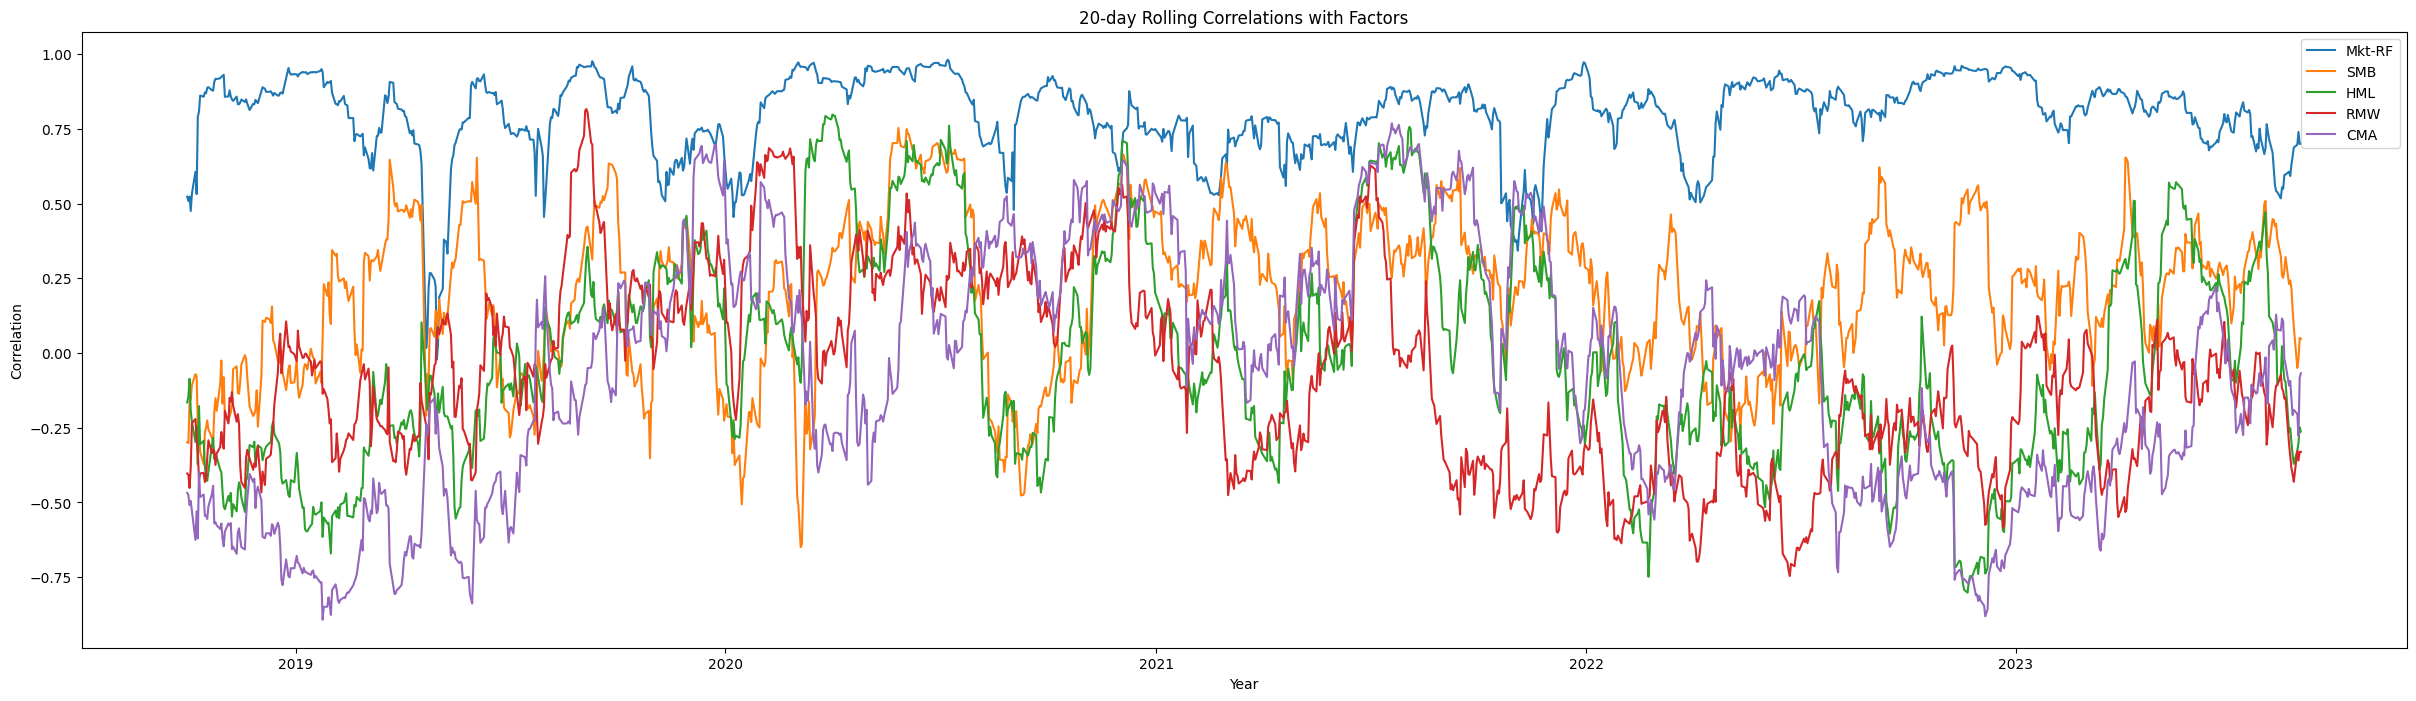

In [27]:
portfolio_factor_correlation("portfolio_minvol", portfolio_factors)

#### From the 20-day rolling time series of correlations in each portfolio above, we can see that only (Mkt-RF) factor is consistently correlated with the all types of portfolio returns, throughout 5 years of our research. SMB factor may look outstanding among the factors but it is similarly volatile to the other 3 factors in our portfolios. Out of the 4 factors, there are none of them which played out consistently throughout 5 years, they were only significant at some time.

### 3. Regress the Portfolio Return on Each Factor and Assess the Portfolio's Sensitivity to Each Factor.
For the curious, optional challenge, how do you test whether the intercept (i.e., alpha) is significantly different from the risk-free rate for a single-factor regression? 

Hint: *Write functions for repetitive lines of codes*

In [28]:
# Import the ols function
import statsmodels.api as sm

factors = ['Mkt-RF','SMB','HML','RMW','CMA']
# function that takes portfolio and factor returns and run a regression of portfolio return on a return factor
# it reports the portfolio sensitivity to a return factor
def portfolio_factor_sensitivity(portfolio_type, df):
    
    ''' 
    INPUTS
    portfolio type: portfolio_ew, portfolio_maxsharpe, portfolio_minvol
    df: dataframe containing portfolio and factor returns
    
    OUTPUTS
    regression result of a portfolio on a return factor
    
    '''    
    for factor in factors:
        
        # Create the model object
        y = df[portfolio_type]
        X = df[factor]
        X = sm.add_constant(X)
        model = sm.OLS(y, X)

        # Fit the model
        model = model.fit()
        robust_results = model.get_robustcov_results(cov_type='HC3')
        
        # Print the parameters of the fitted model
        print(robust_results.summary())
        
        hypotheses = '(const = 0.00019)'
        wald_test = model.wald_test(hypotheses)
        print(wald_test)
        print("*"*100)  

    return 

In [29]:
print(portfolio_factors.dtypes)  # Check data types of all columns

portfolio_ew           float64
portfolio_maxsharpe    float64
portfolio_minvol       float64
Mkt-RF                 float64
SMB                    float64
HML                    float64
RMW                    float64
CMA                    float64
RF                     float64
dtype: object


In [30]:
# Check data types and NaN values and correct if necessary
print(portfolio_factors.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2018-09-04 to 2023-08-31
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   portfolio_ew         1257 non-null   float64
 1   portfolio_maxsharpe  1257 non-null   float64
 2   portfolio_minvol     1257 non-null   float64
 3   Mkt-RF               1257 non-null   float64
 4   SMB                  1257 non-null   float64
 5   HML                  1257 non-null   float64
 6   RMW                  1257 non-null   float64
 7   CMA                  1257 non-null   float64
 8   RF                   1257 non-null   float64
dtypes: float64(9)
memory usage: 98.2 KB
None


In [31]:
portfolio_factor_sensitivity("portfolio_ew", portfolio_factors)

                            OLS Regression Results                            
Dep. Variable:           portfolio_ew   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     495.5
Date:                Wed, 16 Oct 2024   Prob (F-statistic):           8.76e-93
Time:                        05:03:00   Log-Likelihood:                 3842.6
No. Observations:                1257   AIC:                            -7681.
Df Residuals:                    1255   BIC:                            -7671.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.023      0.3

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130:FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


#### (Equally weighted portfolio) For the other factors except 'CMA', we reject the null hypothesis that they are not different than 0 at alpha = 0.01. Overall, with F-test, we got the similar conclusion, except for 'CMA' model, the regression models' coefficients are significantly different than 0 (i.e. fitter than intercept-only model) at the same level of significance, respectively. 

#### Close to 1% sensitivity of portfolio returns to (Mkt-RF) i.e. market risk premium and SMB i.e. Size factors; while RMW i.e profitability negatively affected the returns.  

In [32]:
portfolio_factor_sensitivity("portfolio_maxsharpe", portfolio_factors)

                             OLS Regression Results                            
Dep. Variable:     portfolio_maxsharpe   R-squared:                       0.665
Model:                             OLS   Adj. R-squared:                  0.665
Method:                  Least Squares   F-statistic:                     1714.
Date:                 Wed, 16 Oct 2024   Prob (F-statistic):          6.85e-237
Time:                         05:03:28   Log-Likelihood:                 3850.6
No. Observations:                 1257   AIC:                            -7697.
Df Residuals:                     1255   BIC:                            -7687.
Df Model:                            1                                         
Covariance Type:                   HC3                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      2.41

#### (Max Sharpe Portfolio) For all factors, we reject the null hypothesis that they are not different than 0 at alpha = 0.01. Overall, with F-test, we got the similar conclusion, the regression models' coefficients are significantly different than 0 (i.e. fitter than intercept-only model) at the same level of significance, respectively.

#### Market risk premium (more than 1% sensitivity) and size factors seem positively affected the portfolio returns while the others (almost -1% sensitivity to investment factor) negatively affected them.

In [33]:
portfolio_factor_sensitivity("portfolio_minvol", portfolio_factors)

                            OLS Regression Results                            
Dep. Variable:       portfolio_minvol   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     889.2
Date:                Wed, 16 Oct 2024   Prob (F-statistic):          3.71e-148
Time:                        05:03:30   Log-Likelihood:                 4185.4
No. Observations:                1257   AIC:                            -8367.
Df Residuals:                    1255   BIC:                            -8356.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.109      0.2

#### (Min Volatility Portfolio) For all factors except 'HML' i.e. value factor, we reject the null hypothesis that they are not different than 0 at alpha = 0.01. Overall, with F-test, we got the similar conclusion, except for 'HML' model, the regression models' coefficients are significantly different than 0 (i.e. fitter than intercept-only model) at the same level of significance, respectively.

#### Market risk premium (more than 1% sensitivity) and size factors seemed positively affected the portfolio returns in the past 5 years while profitability and investment (conservative minus aggressive) factors negatively affected them.   

### 4. Regress the Portfolio Return on All Factors and Assess the Portfolio's Sensitivity to Factors.
For the curious, optional challenge, how do you test whether the intercept (i.e., alpha) is significantly different from the risk-free rate for a multi-factor regression?

Hint: *Write functions for repetitive lines of codes*

In [34]:
# Import the ols function
import statsmodels.api as sm

# function that takes portfolio and factor returns and run a regression of portfolio return on a return factor
# it reports the portfolio sensitivity to a return factor
def portfolio_all_factor_sensitivity(portfolio_type, df):
    
    ''' 
    INPUTS
    portfolio type: portfolio_ew, portfolio_maxsharpe, portfolio_minvol
    df: dataframe containing portfolio and factor returns
    
    OUTPUTS
    regression result of a portfolio on a return factor
    
    '''    
        
    # Create the model object
    y = df[portfolio_type]
    X = df[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
    X = sm.add_constant(X)
    model_vs_all = sm.OLS(y,X)

    # Fit the model
    model = model_vs_all.fit()    
    robust_results = model.get_robustcov_results(cov_type='HC3')
    
    # Print the parameters of the fitted model
    print(robust_results.summary())
        
    hypotheses = '(const = 0.00019)'
    wald_test = model.wald_test(hypotheses)
    print(wald_test)
    print("*"*100)  
    
    # test the significance of the model intercept
    

    return 

In [35]:
portfolio_all_factor_sensitivity('portfolio_ew', portfolio_factors)

                            OLS Regression Results                            
Dep. Variable:           portfolio_ew   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     161.3
Date:                Wed, 16 Oct 2024   Prob (F-statistic):          1.95e-132
Time:                        05:03:34   Log-Likelihood:                 4001.3
No. Observations:                1257   AIC:                            -7991.
Df Residuals:                    1251   BIC:                            -7960.
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.482      0.1

#### (Equally Weighted Portfolio) For all factors other than 'SMB', we reject the null hypothesis that they are not different than 0 at alpha = 0.01. Overall, with F-test, either one or some or all coefficients are significantly different than 0 (fitter than intercept-only model) at the same level of significance.

#### About 1% sensitivity of portfolio returns to market risk premium factor while the other factors have less than 1% (only RMW factor negatively affected returns), based on the multiple regression model. 

In [36]:
portfolio_all_factor_sensitivity('portfolio_maxsharpe', portfolio_factors)

                             OLS Regression Results                            
Dep. Variable:     portfolio_maxsharpe   R-squared:                       0.709
Model:                             OLS   Adj. R-squared:                  0.708
Method:                  Least Squares   F-statistic:                     423.1
Date:                 Wed, 16 Oct 2024   Prob (F-statistic):          7.41e-266
Time:                         05:03:37   Log-Likelihood:                 3939.9
No. Observations:                 1257   AIC:                            -7868.
Df Residuals:                     1251   BIC:                            -7837.
Df Model:                            5                                         
Covariance Type:                   HC3                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      2.08

#### (Max Sharpe Portfolio) For all factors other than 'SMB' and 'RMW', we reject the null hypothesis that they are not different than 0 at alpha = 0.01. Overall, with F-test, either one or some or all coefficients are significantly different than 0 (fitter than intercept-only model) at the same level of significance. 


#### More than 1% sensitivity of portfolio returns to market risk premium factor while the other factors have less than 1% (HML was negatively affecting the returns). 

In [37]:
portfolio_all_factor_sensitivity('portfolio_minvol', portfolio_factors)

                            OLS Regression Results                            
Dep. Variable:       portfolio_minvol   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     241.2
Date:                Wed, 16 Oct 2024   Prob (F-statistic):          1.87e-180
Time:                        05:03:39   Log-Likelihood:                 4302.0
No. Observations:                1257   AIC:                            -8592.
Df Residuals:                    1251   BIC:                            -8561.
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.069      0.2

#### (Min Volatility Portfolio) For all factors other than 'SMB' and 'HML', we reject the null hypothesis that they are indifferent than 0 at alpha = 0.01. Overall, with F-test,  either one or some or all coefficients are significantly different than 0 (fitter than intercept-only model) at the same level of significance. 

#### More than 1% sensitivity of portfolio returnsto  market risk premium factor while the other factors have less than 1% (Profitability factor negatively affected the returns). 